In [1]:
import pandas as pd
import seaborn as sns

from s2_analytics import sqlite_import

con, cur = sqlite_import.import_games("logs_ranked/", "/tmp/s2_ranked.sql", period_days=60)

# calculate counts if kills for each date and weapon including rows with 0 values
cur.execute("""
create table weapon_kills_by_date as
    select distinct dw.date,
                    dw.weaponName,
                    sum(iif(timestamp is null, 0, 1)) kills -- count only if not null
    from
        -- all date+weapon combinations
        (select *
         from (select distinct date from event_kill)
                  cross join (select distinct weaponName from event_kill)) dw

        -- join kill events or nulls if nothing found
            left outer join event_kill ek on dw.date = ek.date and dw.weaponName = ek.weaponName

    group by dw.date, dw.weaponName
""")

## Data summary

In [2]:
query = """
select
    datetime(min(id)/1000, 'unixepoch') first_game_start_time,
    datetime(max(id)/1000, 'unixepoch') last_game_start_time,
    count(1) games_count
from game
"""
pd.read_sql_query(query,
                  con)


,first_game_start_time,last_game_start_time,games_count
0,2022-11-12 20:30:59,2023-01-09 23:44:52,702


In [3]:
query = """
select
    playlistCode,
    count(1) games_count
from game group by playlistCode
"""
pd.read_sql_query(query,
                  con)

,playlistCode,games_count
0,CTF-Standard-4,42
1,CTF-Standard-6,655
2,CTF-Standard-8,5


# Weapon usage trends

/tmp/ipykernel_118492/1620412170.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.set_xticklabels(plt.get_xticklabels(), rotation=90)


<AxesSubplot: title={'center': '21-days rolling average of kills percentage'}, xlabel='date', ylabel='kills_percentage_rolling_average_21days'>

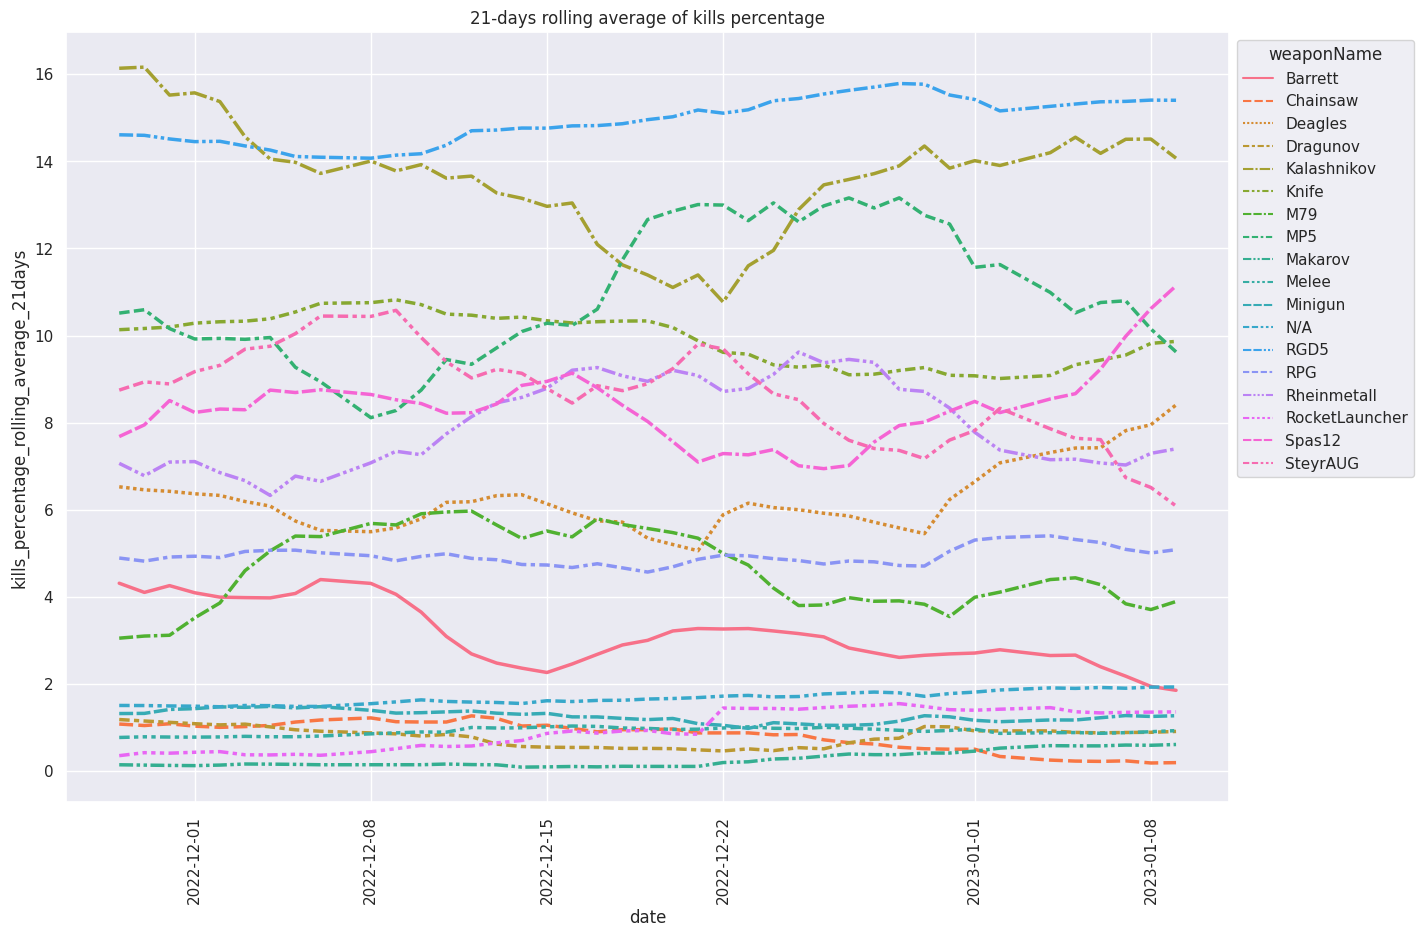

In [4]:
result9 = pd.read_sql_query("""
select
    weaponName,
    date,
    100.0 * kills / (select sum(kills) from weapon_kills_by_date wkd2 where wkd.date = wkd2.date) as kills_percentage
from weapon_kills_by_date wkd
""", con)
result9['date'] = pd.to_datetime(result9['date'])
groupby = result9.groupby("weaponName", as_index=False, group_keys=False)

result9["kills_percentage_rolling_average_7days"] = groupby.apply(
    lambda grp, freq: grp.rolling(freq, on='date', min_periods=5)['kills_percentage'].mean(), "7D")
result9["kills_percentage_rolling_average_21days"] = groupby.apply(
    lambda grp, freq: grp.rolling(freq, on='date', min_periods=17)['kills_percentage'].mean(), "21D")


def generate_rolling_average_plot(df, days):
    sns.set(rc={'figure.figsize': (15, 10)})
    plt = sns.lineplot(df, x="date", y=f"kills_percentage_rolling_average_{days}days", style="weaponName",
                       hue="weaponName", linewidth=2.5)
    plt.set_xticklabels(plt.get_xticklabels(), rotation=90)
    plt.set_title(f"{days}-days rolling average of kills percentage")
    sns.move_legend(plt, "upper left", bbox_to_anchor=(1, 1))
    return plt

generate_rolling_average_plot(result9, 21)

/tmp/ipykernel_118492/1620412170.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.set_xticklabels(plt.get_xticklabels(), rotation=90)


<AxesSubplot: title={'center': '7-days rolling average of kills percentage'}, xlabel='date', ylabel='kills_percentage_rolling_average_7days'>

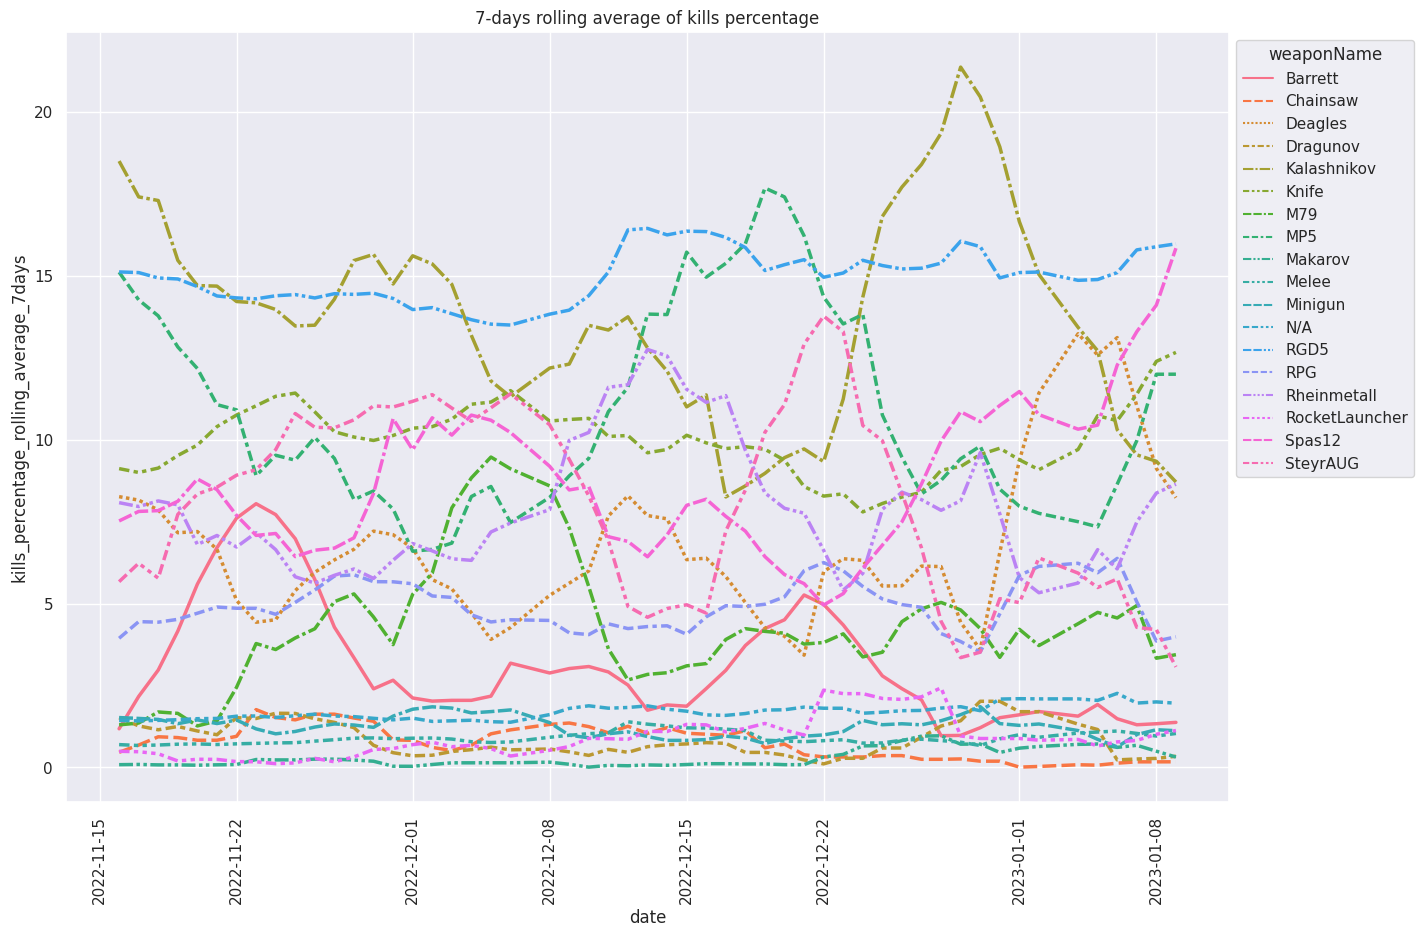

In [5]:
generate_rolling_average_plot(result9, 7)

In [6]:
result9.tail(n=300)

,weaponName,date,kills_percentage,kills_percentage_rolling_average_7days,kills_percentage_rolling_average_21days
726,M79,2022-12-23,5.352529,4.076841,4.727809
727,MP5,2022-12-23,3.026947,13.529041,12.637690
728,Makarov,2022-12-23,0.738280,0.400191,0.210063
729,Melee,2022-12-23,1.402732,0.846527,1.012534
730,Minigun,2022-12-23,0.885936,1.095757,0.977439
...,...,...,...,...,...
1021,RPG,2023-01-09,4.948076,3.985285,5.081448
1022,Rheinmetall,2023-01-09,7.819181,8.641031,7.397712
1023,RocketLauncher,2023-01-09,1.405009,1.127996,1.356525
1024,Spas12,2023-01-09,13.439218,15.839045,11.141244
